In [1]:
%matplotlib inline
%ds_look

import re
import os
import time
import math
import random 
import itertools
import numpy as np
import pandas as pd
import psycopg2
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from collections import defaultdict
from datetime import datetime
from scipy import stats


import pyrothko as rk

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['mathtext.fontset']='custom'

from ds_api import decorators 
from ds_api.ds_components import todo_list

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [8]:
### Jakes function for rothko look
def format_chart(ax,loc=None, horizontal=False):
    """A function to format matplotlib charts top look more rothko-esque
    Can take in a single axis or a list of axes and format each chart. Build your chart
    and then run format_chart() right before plt.show().
    
    Some notes:
    You can pass it a single axis object or a list/tuple/array of axis objects and the 
    function will format them all the same way according to your specifications
    
    If you use plt to manipulate your charts, you have to pass an axis object. Do so
    by passing the function plt.gca().
    
    loc handles the legend. Default is to always include a legend. You can either specify
    a legend location with an integer 0-8 or no legend with loc=False.
    
    horizontal = True is for horizontally oriented charts"""
    
    def formater(ax,horizontal = horizontal, loc=None):
        
        if horizontal:
            #determine the visible spines/ticks and where grids should be
            visible_spines = ['top','bottom','right']
            grid_orientation = ax.xaxis
        else:
            visible_spines = ['top','left','right']
            grid_orientation = ax.yaxis

        #remove spines
        for spine in visible_spines:
            ax.spines[spine].set_visible(False)

        #remove excess ticks
        ax.xaxis.set_tick_params(which='both',top= False if 'top' in visible_spines else True
                                 , bottom = False if 'bottom' in visible_spines else True)
        ax.yaxis.set_tick_params(which='both',left= False if 'left' in visible_spines else True
                                 , right = False if 'right' in visible_spines else True)
        #grids
        ax.grid(False)
        grid_orientation.grid(True)
                
        #white background
        ax.set_axis_bgcolor('w')

        #change legend frame
#         if loc != None:
#             _loc = loc
#         else:
#             _loc = 0
        
#         if loc != False:
#             ax.legend(frameon=False,loc = _loc)    

#         return ax
    

    
    #if list of axes, iterate through the list
    if type(ax) == list:
        new_ax = [formater(x,horizontal,loc) for x in ax]
    else:        
        new_ax = formater(ax,horizontal,loc)

    return new_ax

In [3]:
colors = {
    1: '#6E90A9',
    2: '#7B74AA',
    3: '#C86454',
    4: '#D38252',
    
    5: '#DDA051',
    6: '#E8BE4F',
    7: '#E24A33'
    }


In [2]:
conn = psycopg2.connect(
    database='tradesy',
    port=os.environ['REDSHIFT_PORT'],
    password=os.environ['REDSHIFT_PASS'],
    user=os.environ['REDSHIFT_USER'],
    host=os.environ['REDSHIFT_HOST']
)

In [5]:
@cache()
def query_db(query):
    return pd.read_sql(query, conn)

In [6]:
@cache()
def query_db_chunk_read(query):
    return pd.read_sql(query, conn, index_col=None, coerce_float=True, params=None, parse_dates=None, columns=None, chunksize=None)

# Data

## Brands

### START HERE

In [7]:
query="""
WITH
      brand_ids AS (
            SELECT DISTINCT id as item_type_property_id
            FROM item_type_property
            WHERE LOWER(name) = 'brand'
      )

SELECT a.item_id, LOWER(TRIM(a.item_type_property_value)) as brands
FROM item_data a INNER JOIN brand_ids b
ON a.item_type_property_id = b.item_type_property_id
"""

brands = query_db(query)

transferring from s3


## Favorites

This query removes any favorites due to in-house accounts. It also _excludes_ favorites on deleted or fugly items. Realized that user ID and item ID pairs showed up multiple times in the `favorite` table. Now using `DISTINCT` in the query to `favorite`. Isolating to favorites since July 2015 (to compare vs. original post).

In [8]:
# jr modified query

query="""
SELECT distinct fav.user_id,fav.item_id, fav.created_at, i.category_id, i.brand 
FROM favorite fav inner join item i 
ON i.id=fav.item_id 
WHERE fav.created_at >= '2015-07-01'
AND TRIM(LOWER(i.status)) NOT IN ('deleted', 'fugly')
AND fav.user_id NOT IN (SELECT DISTINCT user_id FROM inhouse_accounts)
"""

f_cb = query_db_chunk_read(query)

transferring from s3


In [9]:
favorites_by_user = pd.DataFrame({'favorites' :
                                  f_cb.groupby('user_id')['user_id'].count()}).reset_index() #get a count of user_ids by user_id

# Data Wrangling

Clean up the text:

* Replace nan with ''
* Remove apostrophes
* Keep only alphanumeric and '&' and '.' characters
* Remove multiple spaces

In [10]:
# Text cleanup
brands['brands'] = brands['brands'].replace(np.nan, '', regex=True)                         \
                                   .apply(lambda x: x.replace("'", ""))                     \
                                   .apply(lambda x: re.sub('[^0-9a-zA-Z\&\.]+', ' ', x))    \
                                   .apply(lambda x: re.sub('\s+', ' ', x).strip())

# Keep only one brand per item
brands.drop_duplicates(subset='item_id', inplace=True)
brands.reset_index(drop=True, inplace=True)

> This post is the first part in response to a follow up request from Steve Elmer at Tradesy on our previous post on [brand favorites](https://app.datascience.com/insights/patterns-emerge-amongst-brands-favorited-together-c8f5i2). As our original post was published in July 2015, we performed a background analysis on how the landscape of favorites has changed in the last 7 months on Tradesy. 

In the first part of this post, we explore the changes in usage of the Favorites feature on Tradesy. In the second part, we explore the most favorited brand combinations among the top 20 most purchased brands. In an upcoming post, we will look at the second tier of top brands to expand on these frequently favorited combinations.

### Key Findings
* The volume of favorites on Tradesy has nearly doubled since July 2015, increasing rapidly after January 2016.
* On average, users are favoriting a higher numbers of items, while prior to July 2015 nearly 45% of users were only favoriting a single item. 
* Chanel, Louis Vuitton and Michael Kors have the highest volume of favorites since July 2015. However, these brands represent a lower percentage of total favorites, as a larger variety of brands are now being favorited.
* Similar to our initial post, we find that users tend to favorite brands within the same price level. 

## Volume of Favorites  is Growing In Recent Months

Prior to updating the brand favorites post, we did a background analysis on the usage of favorites on Tradesy. We found that the unique number of favorites created per week, shown in the chart below, is increasing rapidly since January 2016. In the chart below, we indicate July 2015 as a reference point for the time of this intial analysis.



In [4]:
faves = pd.read_sql("""
    select
    date_trunc('week', created_at) as month,
    count(distinct id) as num_faves
    from favorite
    where created_at > '2010-01-01'
    and created_at < '2016-04-01'
    group by 1"""  , conn)

In [5]:
faves['month'] = pd.to_datetime(faves['month'])

In [6]:
faves = faves.set_index('month')

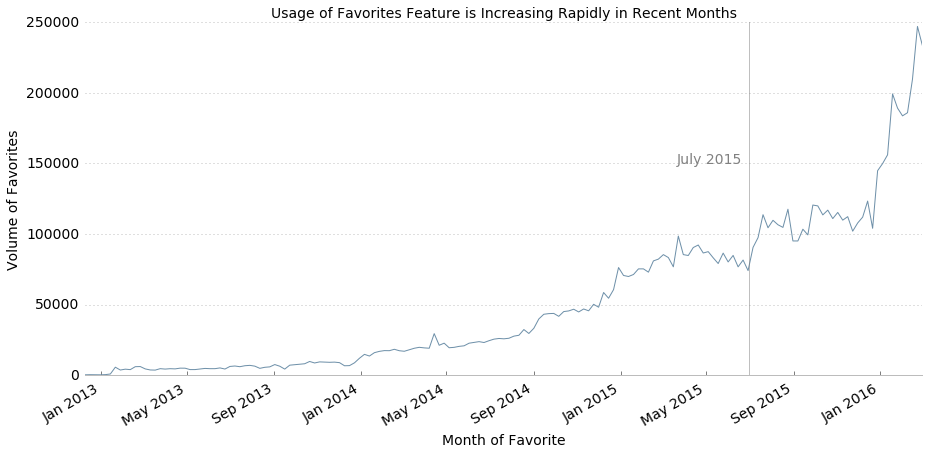

In [9]:
faves.plot(color=colors[1], legend=False)

plt.axvline('2015-07-01', color='grey', alpha=0.5)
plt.text('2015-06-20', 150000, 'July 2015', color='grey', ha='right')
plt.gca().set_xlabel('Month of Favorite')
plt.ylabel('Volume of Favorites')
plt.title('Usage of Favorites Feature is Increasing Rapidly in Recent Months')
format_chart(plt.gca())


Next, we observed the mean number of favorited items per user. Below, we see that the mean number of items favorited per user has increased. At the time of our initial analysis, approximately 45% of users favorited only one item, while that number has now decreased to 30% of users. This indicates that users in the past 6 months are creating more favorites.

This rise in the number of favorites per user, and overall, confirmed the need to initially re-evaluate brand favorites over the past 6 months, prior to expanding this series to other brands.

In [134]:
# jr modified query

query="""
SELECT distinct fav.user_id,fav.item_id, fav.created_at, i.category_id, i.brand,
case when fav.created_at >= '2015-07-01 00:00:00' then 1 else 0 end as is_update
FROM favorite fav inner join item i 
ON i.id=fav.item_id 
WHERE fav.created_at > '2010-01-01'
AND TRIM(LOWER(i.status)) NOT IN ('deleted', 'fugly')
AND fav.user_id NOT IN (SELECT DISTINCT user_id FROM inhouse_accounts)
"""

before_after_faves = query_db_chunk_read(query)

file exists in cache


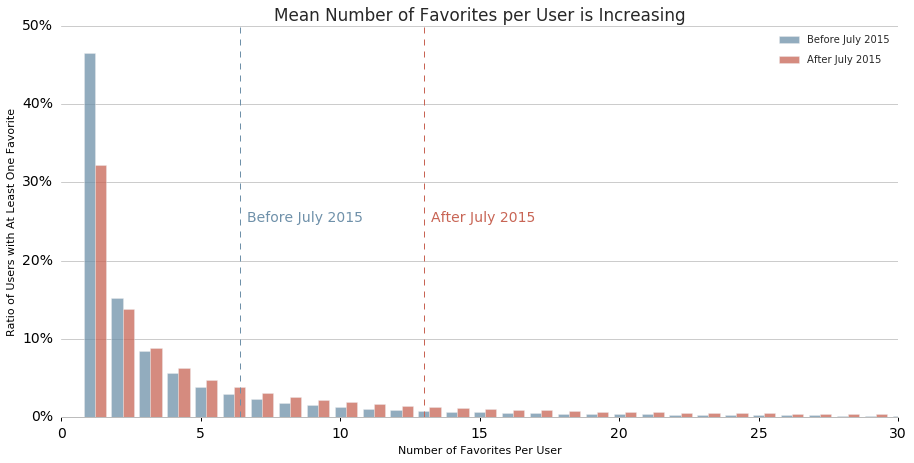

In [132]:
before = before_after_faves[before_after_faves['is_update']==0].groupby(['user_id']).item_id.nunique().reset_index().item_id.values
after = before_after_faves[before_after_faves['is_update']==1].groupby(['user_id']).item_id.nunique().reset_index().item_id.values

b = np.arange(0,100, 1)

bvals, bbins = np.histogram(before, bins=b, normed=True)
avals, abins = np.histogram(after, bins=b, normed=True)

plt.bar(bbins[:-1]-.2, bvals, width=0.4, color=colors[1], alpha=0.75, label='Before July 2015')
plt.bar(abins[:-1]+.2, avals, width=0.4, color=colors[3], alpha=0.75, label='After July 2015')

plt.axvline(before.mean(), color=colors[1], linestyle='--')
plt.text(before.mean()+.25, 0.25, 'Before July 2015', color=colors[1],)
plt.axvline(after.mean(), color=colors[3],  linestyle='--')
plt.text(after.mean()+.25, 0.25, 'After July 2015', color=colors[3] )
plt.xlim(0,30)

plt.gca().set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])

plt.xlabel("Number of Favorites Per User")
plt.ylabel("Ratio of Users with At Least One Favorite")

plt.legend()
plt.title('Mean Number of Favorites per User is Increasing')
format_chart(plt.gca())

In [17]:
# Remove null user IDs
f_cb = f_cb[~pd.isnull(f_cb.user_id)]

In [18]:
f_cb.shape

(3601824, 5)

In [19]:
# Add brands
f_cb = pd.merge(f_cb, brands, on='item_id') # inner is default

In [20]:
f_cb.shape

(1475639, 6)

In [21]:
# # Number of favorites by user and brand
# f_user_brand = pd.DataFrame({'favorites' :
#                              f_cb.groupby(['user_id', 'brands'])\
#                              ['brands'].count()}).reset_index()

# # Number of favorited brands
# fub_brands = pd.DataFrame({'n_f_brands' :
#                            f_user_brand.groupby('user_id')['user_id'].count()}).reset_index()

# # Total number of favorites
# fub_favorites = pd.DataFrame({'N_f' :
#                               f_user_brand.groupby('user_id')['favorites'].sum()}).reset_index()

# # Merge
# fub = pd.merge(fub_brands, fub_favorites, on='user_id')

### Favorited

In [22]:
# Remove: 'other', 'unknown', ''
fb_clean = f_cb[~f_cb.brands.isin(['other', 'unknown', ''])]

# Counts
fb = pd.DataFrame({'count' :
                   fb_clean.groupby('brands')['brands'].count()}).reset_index()
fb.sort('count', inplace=True, ascending=False)
fb.reset_index(drop=True, inplace=True)

# Top 20
fb20 = fb[-20:]
fb20.reset_index(drop=True, inplace=True)

# List
fb20_list = fb20.brands.tolist()
fb20_labels = [b.title() for b in fb20_list]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


### Purchased

In [24]:
query="""
WITH
    i AS (
        SELECT DISTINCT id as item_id
        FROM item
        WHERE TRIM(LOWER(status)) NOT IN ('deleted', 'fugly')
    ),
    p AS (
        SELECT DISTINCT item_id FROM purchase
        where created_at > '2015-07-01'
    )

SELECT p.*, 1 as purchased
FROM i INNER JOIN p
ON i.item_id = p.item_id


"""

purchased = query_db(query)

transferring from s3


In [25]:
# ### top purchased brands
# pb = pd.read_sql("""
#     select
#     lower(i.brand) as brands,
#     count(distinct p.id)
#     from item i
#     left join purchase p
#     on p.item_id = i.id
#     where
#     p.status not like ('%cancelled%')
#     and p.created_at > '2015-07-01'
#     group by 1
# """, conn)
# pb = pb[~pb.brands.isin(['other', 'unknown', 'other'])]


In [26]:
# Only purchased brands
pb = pd.merge(purchased, brands, on='item_id')

# Remove: 'other', 'unknown', ''
pb = pb[~pb.brands.isin(['other', 'unknown', ''])]

#Counts
pb = pd.DataFrame({'count' : pb.groupby('brands')['brands'].count()}).reset_index()
pb.sort('count', inplace=True)
pb.reset_index(drop=True, inplace=True)

# Top 20
pb20 = pb[-20:]
pb20.reset_index(drop=True, inplace=True)

# # List
pb20_list = pb20.brands.tolist()
pb20_labels = [b.title() for b in pb20_list]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [27]:
pb20

,brands,count
0,juicy couture,924
1,dooney & bourke,937
2,lilly pulitzer,991
3,diane von furstenberg,992
4,anthropologie,1154
5,free people,1196
6,banana republic,1244
7,tiffany & co.,1245
8,lululemon,1745
9,prada,2021


## Purchased Brands (Mean Price)

In [28]:
# mean_price = pd.read_sql(
# """
# select i.brand as brands,
# sum(p.total) as total,
# count(distinct p.id) as num_items
# from purchase p
# left join item i
# on p.item_id = i.id
# where p.status not like ('%cancelled%')
# and p.created_at > '2015-07-01'
# and lower(i.brand) similar to '%(""" + ("|").join(str(e) for e in pb20_list)+ """%)'
# group by 1
# """ , conn)

# mean_price['price'] = mean_price['total'] / mean_price['num_items']

In [1]:
query="""
WITH
    i AS (
        SELECT DISTINCT id as item_id
        FROM item
        WHERE TRIM(LOWER(status)) NOT IN ('deleted', 'fugly')
    ),
    p AS (
        SELECT DISTINCT item_id, total FROM purchase
        where created_at > '2015-07-01'

    )

SELECT p.*, 1 as purchased
FROM i INNER JOIN p
ON i.item_id = p.item_id
"""

purchased_prices = query_db(query)

NameError: name 'query_db' is not defined

In [30]:
# Get average total price for sorting
mean_price = pd.merge(purchased_prices, brands, on='item_id')

mean_price = mean_price[['item_id', 'total', 'brands']]
print mean_price.shape
mean_price.drop_duplicates(inplace=True)
print mean_price.shape
mean_price = pd.DataFrame({'price' :
                           mean_price.groupby('brands')\
                           ['total'].mean()}).reset_index()
mean_price = mean_price[mean_price.brands.isin(pb20_list)]
mean_price.sort('price', ascending=False, inplace=True)
mean_price.reset_index(drop=True, inplace=True)
mean_price['rank'] = mean_price.index

(165106, 3)
(165106, 3)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


## Brand Combinations

In [31]:
def pair_counter(df):
    pair_counts = defaultdict(int)
    for u in np.sort(df.user_id.unique()):
        b = df[df.user_id == u].brands.values.tolist()
        for p in itertools.combinations(b, 2):
                pair_counts[p] += 1
    return pair_counts


@cache()
def count_pairs():
    # Data & drop duplicates
    f_data = fb_clean[['user_id', 'brands']]
    f_data.drop_duplicates(inplace=True)

    # >1 distinct brand favorited
    oneplus_id = pd.DataFrame({'count' :
                                f_data.groupby('user_id')\
                                ['user_id'].count()}).reset_index()
    oneplus_id = oneplus_id[oneplus_id['count'] > 1]
    
    # Data
    f_data = pd.merge(f_data, oneplus_id, on='user_id')
    f_data.sort(['user_id', 'brands'], inplace=True)
    f_data.reset_index(drop=True, inplace=True)
    
    # Count brand pairs
    pair_counts = pair_counter(f_data)
    
    # Only keep pairs that show up more than once
    pair_counts = { k:v for k, v in pair_counts.items() if v > 1 }
    
    return (f_data, pair_counts)

In [32]:
# Data and counts
f_data, pair_counts = count_pairs()

transferring from s3


In [113]:
# Create the DataFrame from the dictionary
tdf = pd.DataFrame({'pairs' : pair_counts.keys(), 'counts' : pair_counts.values()})

In [117]:
tdf.sort('counts', ascending=False)[100:140]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,counts,pairs
652302,1297,"(gucci, marc by marc jacobs)"
984558,1289,"(giuseppe zanotti, gucci)"
287135,1275,"(banana republic, j.crew)"
33386,1267,"(jimmy choo, tory burch)"
480994,1258,"(michael kors, zara)"
216562,1251,"(gucci, marc jacobs)"
794713,1250,"(marc jacobs, michael kors)"
124191,1250,"(chanel, j.crew)"
826635,1241,"(chanel, rolex)"
435403,1237,"(gucci, yves saint laurent)"


In [112]:
tdf.sort('percent', ascending=False)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,first,percent,second
880975,Louis Vuitton,0.085860,Chanel
880975,Chanel,0.085860,Louis Vuitton
194734,Gucci,0.078827,Louis Vuitton
194734,Louis Vuitton,0.078827,Gucci
1054541,Louis Vuitton,0.057343,Christian Louboutin
1054541,Christian Louboutin,0.057343,Louis Vuitton
352262,Gucci,0.056277,Chanel
352262,Chanel,0.056277,Gucci
641919,Tory Burch,0.052903,Louis Vuitton
641919,Louis Vuitton,0.052903,Tory Burch


In [35]:
# Normalize by the number of users
tdf['percent'] = tdf['counts'] / len(f_data.user_id.unique())

# Split the tuple values into columns
tdf['first'] = tdf['pairs'].str[0]
tdf['second'] = tdf['pairs'].str[1]

In [36]:
# David's Bridal
davids_bridal = tdf[tdf['first'] == 'davids bridal']
davids_bridal.sort('percent', ascending=False, inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:3225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  na_position=na_position)


In [37]:
# Subset: only top 20 purchased brands
pbtop20 = pb20.sort('count', ascending=False)[0:20]['brands'].tolist()
tdf = tdf[(tdf['first'].isin(pbtop20)) & (tdf['second'].isin(pbtop20))]
tdf = tdf[['first', 'second', 'percent']]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [38]:
tdf

,first,second,percent
1013,chanel,tory burch,0.034814
10334,free people,kate spade,0.008835
14035,coach,lilly pulitzer,0.004077
30752,gucci,prada,0.042573
36352,burberry,louis vuitton,0.045562
39481,anthropologie,prada,0.006088
41992,louis vuitton,michael kors,0.048155
43156,burberry,tiffany & co.,0.011000
45338,free people,gucci,0.006824
49987,banana republic,coach,0.008495


In [39]:
# Format brand names
tdf['first'] = tdf['first'].apply(lambda x: x.title())
tdf['second'] = tdf['second'].apply(lambda x: x.title())

for b in ['first', 'second']:
    tdf[b] = tdf[b].apply(lambda x: 'David\'s Bridal' if x == 'Davids Bridal' else x)
    tdf[b] = tdf[b].apply(lambda x: 'J. Crew' if x == 'J.Crew' else x)
    tdf[b] = tdf[b].apply(lambda x: 'Victoria\'s Secret' if x == 'Victorias Secret' else x)

In [40]:
# Symmetric Data
tdf0 = tdf.copy()
tdf1 = tdf.copy()
tdf1.columns = ['second', 'first', 'percent']

# Combine
tdf = tdf0.append(tdf1)

In [41]:
# Matrix
hm_data = tdf.pivot('first', 'second', 'percent')
hm_data.fillna(0, inplace=True)

In [42]:
mean_price

,brands,price,rank
0,chanel,924.127438,0
1,louis vuitton,566.286079,1
2,christian louboutin,536.426729,2
3,gucci,320.646693,3
4,prada,280.082125,4
5,tiffany & co.,267.222783,5
6,burberry,246.153658,6
7,tory burch,135.790162,7
8,kate spade,109.988995,8
9,michael kors,109.949110,9


In [43]:
# Price rankings
mp = mean_price[['brands', 'rank']].sort('brands')

# Sort matrix (by expensive brands)
hm_data_sorted = hm_data.copy()
hm_data_sorted['rank'] = mp['rank'].values
hm_data_sorted.sort('rank', inplace=True)
col_order = hm_data_sorted.index
hm_data_sorted = hm_data_sorted[col_order]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


# Visualizations

## Number of Favorites per Brand

Next, we identify the most popular brands on Tradesy, in terms of number of favorites since July 2015. This includes only items for which we had brand details and excludes brands listed as "unknown" or "other." Chanel now has the highest percentage of favorites. More interestingly, we see the percentage of favorites among the top brands drop. In our first post, the top brands received as high as 10% of all favorites. Now, the highest percentage is around 3.75%. This indicates that users are favoriting a wider variety of brands in the last 6 months.

In [70]:
faves = fb_clean.groupby('brands').item_id.nunique().reset_index()
fb20_labels = faves.sort('item_id', ascending=False).head(20)['brands'].str.title().tolist()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [71]:
# Label formatting
fb20_labels = ['J. Crew' if b == 'J.Crew' else b for b in fb20_labels]
fb20_labels = ['David\'s Bridal' if b == 'Davids Bridal' else b for b in fb20_labels]
fb20_labels = ['Hermes' if b == 'Herm S' else b for b in fb20_labels]
fb20_labels = ['Celine' if b == 'C Line' else b for b in fb20_labels]
fb20_labels = ['Victoria\'s Secret' if b == 'Victoria S Secret' else b for b in fb20_labels]

In [72]:
faves20 = faves.sort('item_id', ascending=False).head(20)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [73]:
faves20 = faves20.set_index('brands')

In [74]:
faves20.item_id = faves20.item_id *100.0 / faves.item_id.sum()

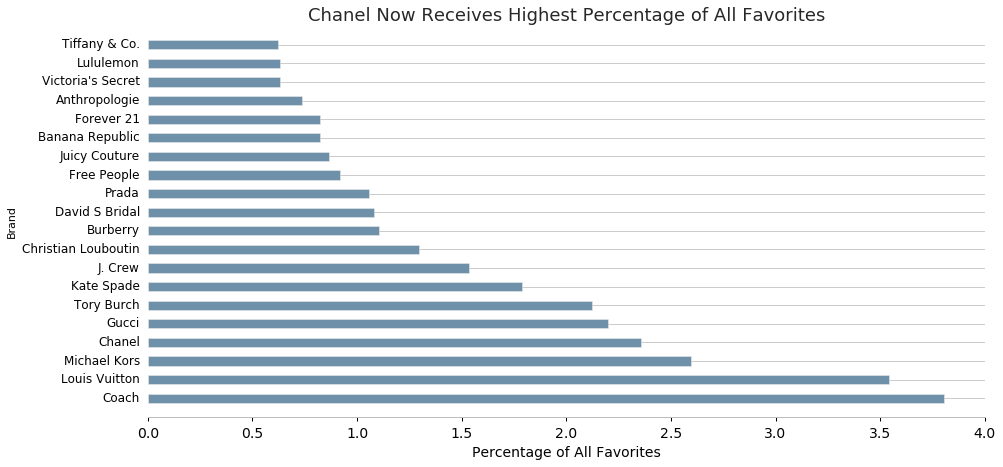

In [107]:
faves20.plot(kind='barh', legend=False)
# Title
plt.title('Chanel Now Receives Highest Percentage of All Favorites', fontsize=18)

# y-axis limit
plt.ylim(ymin=-1, ymax=20)

# Axis ticks
# plt.xlim(0,1)
# plt.xticks(np.linspace(0,0.5,6),
#            [str(int(np.floor(x*100.0))) + "%" for x in np.linspace(0,0.5,6)])

plt.yticks(range(0, len(fb20_labels)), fb20_labels, fontsize=12)

# x-axis labels
plt.xlabel('Percentage of All Favorites', fontsize=14)

# tot_nb_favs=pd.read_sql("""select sum(1) as cnt from favorite""",conn)
# print tot_nb_favs.cnt.values

# Plots
#plt.barh(faves20['item_id'], faves20.index)

plt.ylabel('Brand')

# Remove grid
plt.grid(axis='y')

# Tick marks
plt.tick_params(axis='x', top='off', bottom='off')
plt.tick_params(axis='y', left='on', right='off')

format_chart(plt.gca())


# Brand Associations Among Favorites

Finally, we look at brands frequently favorited together since July 2015.

We used the same methodology as our initial evaulatin to assess and quantify how brands are favorited together. We focus on users who favorited at least two distinct brands in the plot below. For each list of favorites, we identify distinct pairs of brands, regardless of order. For example, a user who only favorited Gucci, Louis Vuitton, and Prada items generate three brand pairs:

- Gucci and Louis Vuitton
- Gucci and Prada
- Louis Vuitton and Prada

We created the following heatmap where each cell represents the proportion of users who favorited a particular combination. The plot shows the combinations for the 20 most purchased brands on Tradesy.

We sort the axes, in descending order, based on the average selling price for items of each brand. This view makes it easier to identify favoriting patterns.

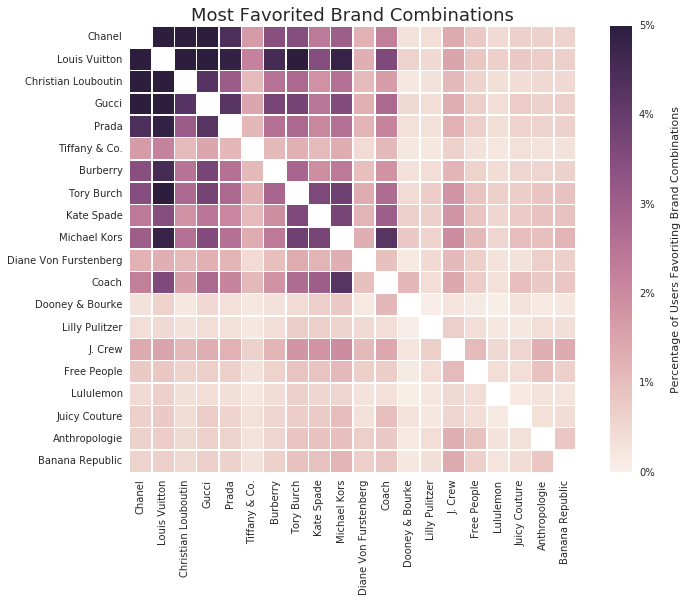

In [47]:
import seaborn as sns
sns.set(style='white')

fig = plt.figure(figsize=(12, 8))

cbar_kws = {'format' : '%.0f%%',
            'label' : '\nPercentage of Users Favoriting Brand Combinations'}

sns.heatmap(hm_data_sorted * 100,
            mask=hm_data_sorted==0,
            vmax=0.05 * 100,
            square=True,cbar_kws=cbar_kws)

# Title
plt.title('Most Favorited Brand Combinations', fontsize=18)

# No axis labels
plt.xlabel('')
plt.ylabel('')

In [48]:
davids_bridal[:5]

,counts,pairs,percent,first,second


We see consistent patterns emerge from this plot:

- Expensive brands tend to get favorited most often. Users who favorite these high-end brands are likely to favorite other high-end brands and not less desirable brands.
- We see new brands rising in rank among the top purchased and top favorites since July 2015 - including Diane Von Furstenberg, Dooney & Bourke and Lilly Pulitzer. We also see brands that are no longer among the top 20 including Ugg Boots and David's Bridal.

Of course, favorites are most meaningful when they are associated with brands that get purchased. It is important to note that the most favorited items are not necessarily the most purchased. We believe there might be a relationship, though, and it's something we plan to explore in a future post.

# Concluding Thoughts 

In this post we provide an update of our initial evaluation of brand favorites in July 2015. We found that the landscape of brands favorited, and the usage pattern of the favorites features has increased rapidly since our initial evaluation. This is additionally interesting as our recent work with the Tradesy LTV model shows that the [usage of favorites is associated with higher purchase frequencies](https://app.datascience.com/insights/user-favorites-correspond-to-increased-purchase-frequency-e6j1a0). In an upcoming post, we will be completing the initial follow up request to expand this post to the next 20 brands to investigate favoriting patterns for those brands. 

# Methodology

Our primary data source for this analysis is the `favorite` table. It includes user and item IDs as well as date and time associated with each action. We interpret the table to represent instances of users favoriting an item.

Our exploratory work with this table, however, revealed several duplicate user and item ID pairs. In most cases, the "created at" field was different for particular user and item ID combinations. Often times, the difference was a few minutes. There are cases, though, where the difference is in days. In counting favorites, we only include distinct user and item ID pairs. In addition to this, we remove favorites associated with deleted or fugly items as well as those from in-house accounts.

We obtain brand information by joining the `item_data` and `item_type_property` tables, which is then associated with particular items based on the item ID. We exclude favorites for items whose brands are listed as either "other" or "unknown" or which are missing.

In [49]:
todos =  [ 'Expand the brand combinations to less popular brands'  
         , 'Explore the connection between favorites and sales'
         , 'Look at how favorites are distributed across categories'
         , 'Stop right here. We already know all this.']
todo_list(todos=todos)